In [2]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
import itertools
import pickle
plt.style.use('fivethirtyeight') # For plots
import os
#Author: Vatsala

In [3]:
#import fbprophet
#fbprophet.__version__

In [4]:
#import utils

In [5]:
plot_file_path ="../prophetForecastPlots/Plot"
plot_data_path ="../plotData/"

In [6]:
#### Specify Plot ID

In [7]:
plotId = "1"

In [8]:
#### Create directory for storing facebook prophet forecasts

In [9]:
# define the name of the directory to be created for the png outputs

path_image = plot_file_path+str(plotId)

try:
    if not os.path.exists(path_image):     
         os.mkdir(path_image)
except OSError:
    print ("Creation of the directory %s failed" % path_image)
else:
    print ("Successfully created the directory %s " % path_image)

Successfully created the directory ../prophetForecastPlots/Plot1 


In [10]:
#****** Running Forecast for Plot 1 *******  Note: Data has been QC-ed

#read Plot 1 data
data = read_excel('../plotData/plotData_'+plotId+'.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [11]:
#print(data.head(10))
#data.dtypes

In [12]:
#This dataframe will be used for running in the Prophet model
#Extract only datetime and flux from the series

dataframe = DataFrame()
dataframe['Flux']  = data['flux']
dataframe['ghg']   = data['ghg']
#dataframe

In [ ]:
#Plot the data  - use dataframe 
#dataframe.set_index('DateTime').plot(style='--', figsize=(15,5), title='Flux Data')   #USE when index has not beem set when loading the data file

#dataframe.plot(style='-', figsize=(15,5), title='Flux Data')
#plt.show()

# Plot by each different gas
#fig, axs = plt.subplots(3, figsize=(15,15))
fig, axs = plt.subplots(1, figsize=(10,5))

#df_CH4dry = dataframe[dataframe['ghg'] == 'CH4_dry']
#df_N2Odry = dataframe[dataframe['ghg'] == 'N2O_dry']

df_CO2dry = dataframe[dataframe['ghg'] == 'CO2_dry']

axs.plot(df_CO2dry['Flux'], color='blue')
#axs[1].plot(df_N2Odry['Flux'], color='red')
#axs[2].plot(df_CO2dry['Flux'], color='green')

#axs.legend(['CH4_dry'])
#axs[1].legend(['N2O_dry'])
axs.legend(['CO2_dry'])

plt.show()

In [14]:
### Feature Engineering

In [15]:
#create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.
#Feature Engineering  - feature used to visualise the data
def create_features(df, label=None):
    '''Create time series features from date time index'''
    df = df.copy()
    df['date']        = df.index #df['DateTime']  #.index
    df['hour']        = df['date'].dt.hour
    df['dayofmonth']  = df['date'].dt.day
    df['month']       = df['date'].dt.month
    df['year']        = df['date'].dt.year
    df['weekofyear']  = df['date'].dt.weekofyear
    df['dayofweek']   = df['date'].dt.dayofweek
    df['dayname']     = df['date'].dt.day_name() 
   
    X = df[['year', 'month', 'dayofmonth', 'weekofyear', 'hour', 'dayofweek', 'dayname']]  #features should be a matrix
    
    if label:
        y = df[label]   #target
        return X,y
    return X

In [16]:
X, y            = create_features(df_CO2dry, 'Flux')    #the target is the flux in this case; the features = X (as shown above)
features_target = pd.concat([X, y], axis=1)  #concatenate the features and the target
#features_target.head()

In [ ]:
#plt.figure(figsize=(30,20))
sns_plot = sns.pairplot(features_target.dropna(), diag_kind="kde", markers="+", hue='hour', 
                  x_vars=['month', 'dayofmonth','weekofyear','hour'],
                  y_vars='Flux',
                      
                  plot_kws=dict(s=70, edgecolor="b", linewidth=4),
                  diag_kws=dict(shade=True))

#year_value = features_target['year'].iloc[0]      

plt.suptitle('CO2 Gas Flux by Month, Day of month, Week of Year and by hour/ '+str(features_target['year'].iloc[0])+' - Plot '+plotId, fontsize=22, y=1.02)

sns_plot.fig.set_figwidth(20)
sns_plot.fig.set_figheight(10)

#For plotting month
sns_plot.axes[0][0].set_xlim(1,6)
sns_plot.axes[0][0].set_ylim(None, None)

##For plotting year
#df1_year=features_target.dropna(axis=0)
## Get hold of the 'Axes' objects
#sns_plot.axes[0][0].set_xticks(df1_year['year'])
#sns_plot.axes[0][0].set_ylim(None, None)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CO2_gasflux_Plot"+plotId+"_features.png" 
# save as png
sns_plot.savefig(plot_file_name)

#plt.show()

### The second part of the code uses Prophet model to draw forecast on the historical data - for the given Plot

#### The reason to use Prophet is that:
It can be seen from the above plot (Flux Data) that there is roughly constant level (the mean of hourly flux). The seasonal fluctuation and random fluctuations roughly are constant in size over time. This suggests that it’s probably appropriate to describe the data using an additive model which is Prophet built on.

### Split the data into training and test data set for CO2_dry gas 
Training data set - March till May 2019

Test data set     - June 2019 

In [18]:
#Train Test - split data
split_date = '31-May-2019'

dataf = df_CO2dry.dropna(axis=0)  #HERE USE DATAFRAME not features_target(this is for visualising)

dataframe_train_CO2dry = dataf.loc[dataf.index <= split_date].copy()
dataframe_test_CO2dry  = dataf.loc[dataf.index > split_date].copy()

#print(dataframe_test_CO2dry.head(10))
#print(dataframe_train_CO2dry.head(10))

### Visualise the training and test data sets

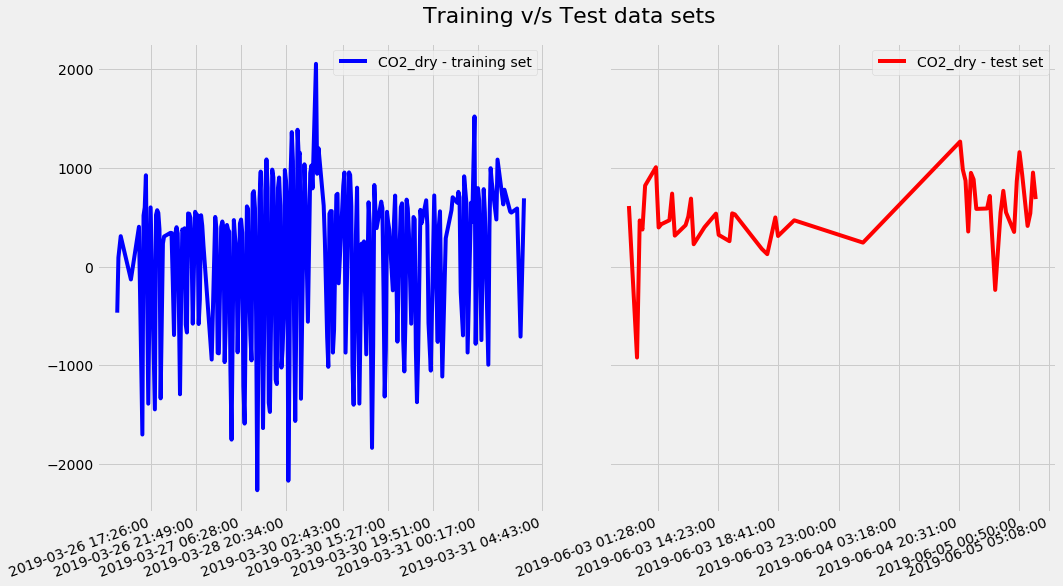

In [19]:
#Visualise the training and test data sets
fig, (axs) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(15,8))
fig.suptitle("Training v/s Test data sets", fontsize=22)
fig.tight_layout(pad=3.0)

df_CO2dry = dataframe[dataframe['ghg'] == 'CO2_dry']

axs[0].plot(dataframe_train_CO2dry['Flux'], color='blue')
axs[0].set_xticklabels(dataframe_train_CO2dry.index, rotation=20, ha='right')

axs[1].plot(dataframe_test_CO2dry['Flux'], color='red')
axs[1].set_xticklabels(dataframe_test_CO2dry.index, rotation=20, ha='right')

axs[0].legend(['CO2_dry - training set'])
axs[1].legend(['CO2_dry - test set'])

plt.show()

### Remove any outliers from the training datasets  - 
- seems none
- test data sets hold few outliers

### Check for any seasonal patterns in the gas flux

In [20]:
### Format training data for prophet model using ds and y

In [21]:
#dataframe_train_CO2dry

In [22]:
dataframe_train_CO2dry = dataframe_train_CO2dry.drop('ghg', axis=1)  #, errors='ignore'

#dataframe_train_CO2dry

In [23]:
#### Do the same for the test data set

In [24]:
dataframe_test_CO2dry = dataframe_test_CO2dry.drop('ghg', axis=1)   #, errors='ignore'

#dataframe_test_CO2dry.to_csv('testco2.csv') 

## Forecasting CO2_dry 

#### Display the distribution of the CO2_dry gas flux  

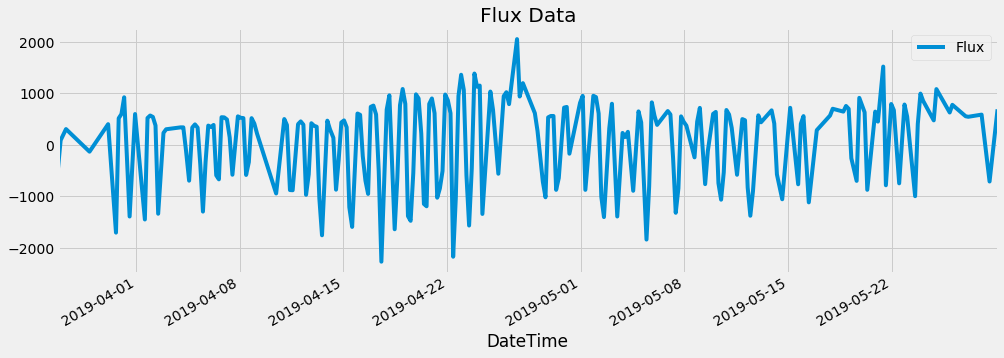

In [25]:
dataframe_train_CO2dry.plot(style='-', figsize=(15,5), title='Flux Data')

### ### Visualising gas flux for one particular day

In [26]:
#Choose one particular gas
#Choose one day from the dataset
dataframe_train_CO2dry_hourly = dataframe_train_CO2dry.copy()

df         = DataFrame()
df['date'] = pd.to_datetime(dataframe_train_CO2dry_hourly.index)  

start_date = '2019-04-25'
end_date   = '2019-04-26'

df1 = dataframe_train_CO2dry_hourly[((dataframe_train_CO2dry_hourly.index >= start_date) & (dataframe_train_CO2dry_hourly.index < end_date))]
                                    
print(df1)

                          Flux
DateTime                      
2019-04-25 02:14:00   680.3637
2019-04-25 10:51:00  -558.4424
2019-04-25 19:35:00   948.4666
2019-04-25 23:53:00  1024.4490


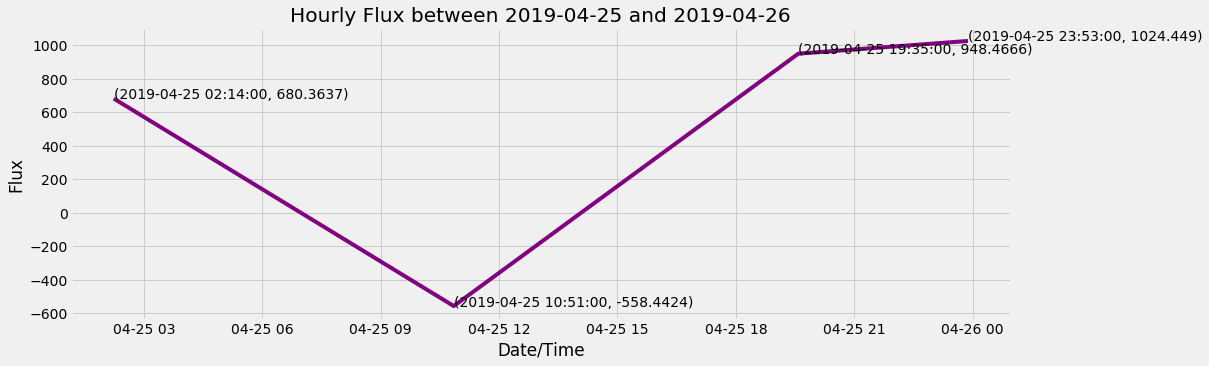

In [27]:
# Create figure and plot space
df2 = df1.reset_index()

fig, ax = plt.subplots(figsize=(15, 5))

# Add x-axis and y-axis
ax.plot(df2['DateTime'],
        df2['Flux'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Flux",
       title="Hourly Flux between "+start_date+" and "+end_date)

#plt.plot(A,B)
for xy in zip(df2['DateTime'], df2['Flux']):                                     
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 


#plt.grid()   
plt.show()

##### Note: There is a decrease from night till early morning, increase from morning till night.

### Visualising gas flux per day of week

In [28]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

seriesObj_f = features_target['dayofweek']

df_f = seriesObj_f.to_frame()

#Merge with dataframe

df_all = dataframe.copy()

df_merge_col_all = pd.merge(df_f, df_all, on='DateTime')


df_merge_col_all

for index, row in df_merge_col_all.iterrows():
    row.dayofweek = days[int(row.dayofweek)]  #convert datetime object to string
    df_merge_col_all.loc[index, 'dayofweek'] = row.dayofweek

df_merge_col_co2 = df_merge_col_all[df_merge_col_all['ghg'] == 'CO2_dry']

df_merge_col_co2.reset_index(drop=True, inplace=True)
#df_merge_col_co2

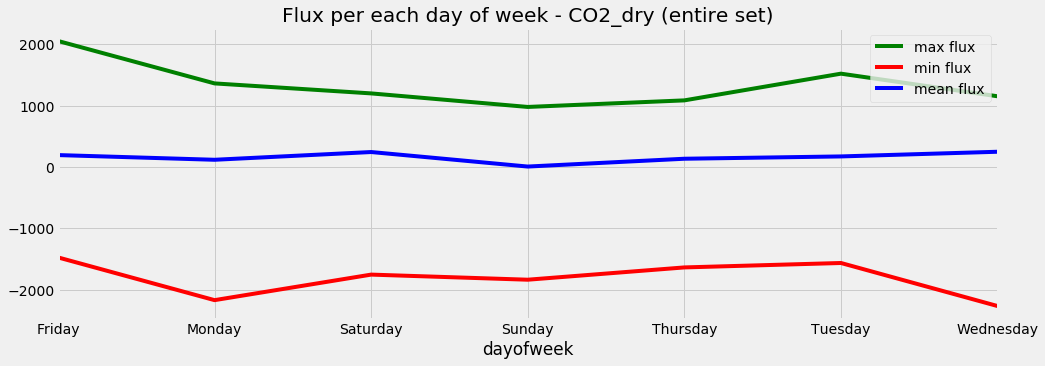

In [29]:
#Plot the training dataset
fig, ax = plt.subplots(figsize=(15, 5))

ax = plt.gca()

df_all = df_merge_col_co2
df_all.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
df_all.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
df_all.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
ax.legend(["max flux", "min flux", "mean flux"])
ax.title.set_text("Flux per each day of week - CO2_dry (entire set)")
plt.show()

#### Visualising Test set

In [30]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

seriesObj_f = features_target['dayofweek']

df_f = seriesObj_f.to_frame()

#Merge with test dataframe
df_te = dataframe_test_CO2dry.copy()

df_merge_col_1 = pd.merge(df_f, df_te, on='DateTime')


df_merge_col_1

for index, row in df_merge_col_1.iterrows():
    row.dayofweek = days[int(row.dayofweek)]  #convert datetime object to string
    df_merge_col_1.loc[index, 'dayofweek'] = row.dayofweek

df_merge_col_1.reset_index(drop=True, inplace=True)
#df_merge_col_1

In [31]:
##Plot the test dataset
#fig, ax = plt.subplots(figsize=(15, 5))

#ax = plt.gca()

#df = df_merge_col_1
##print(df.groupby('dayofweek').sum())
#df.groupby('dayofweek').max().plot(kind='line', ax=ax, color='green')
#df.groupby('dayofweek').min().plot(kind='line', ax=ax, color='red')
#df.groupby('dayofweek').mean().plot(kind='line', ax=ax, color='blue')
#ax.legend(["max flux", "min flux", "mean flux"])
#ax.title.set_text("Hourly Flux per each day of week - CO2_dry (test set)")
#plt.show()

##### Note: Maximum flux in training data set = 1000

### Generate Simple Prophet Model for CO2_dry gas 

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


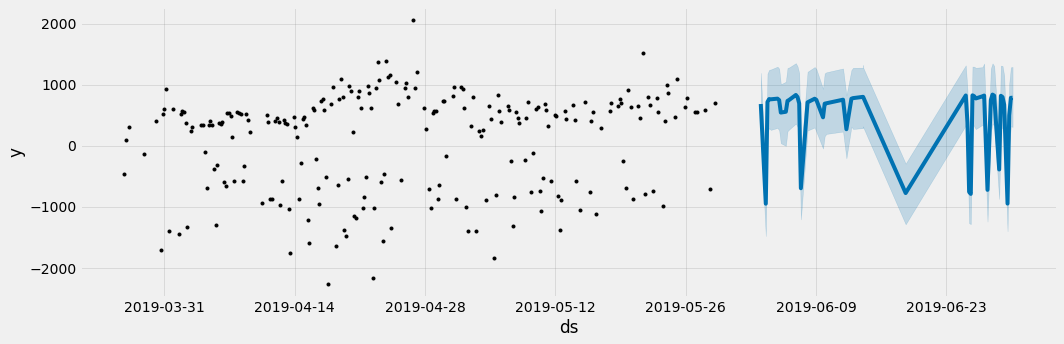

In [32]:
m31 = Prophet() 
m31.fit(dataframe_train_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))
forecast1_co2 = m31.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m31.plot(forecast1_co2,ax=ax)
plt.show()

### Plot the components of the model

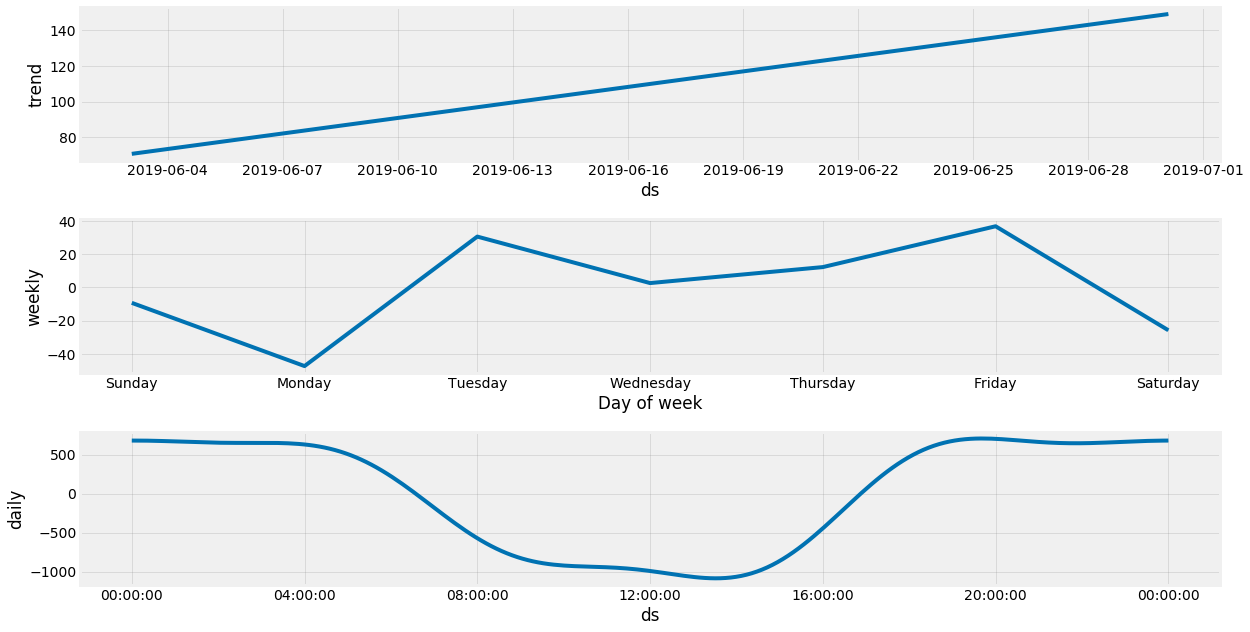

In [33]:
fig = m31.plot_components(forecast1_co2)
fig.set_figwidth(20)

### Compare Actual to Forecasted Simple Model

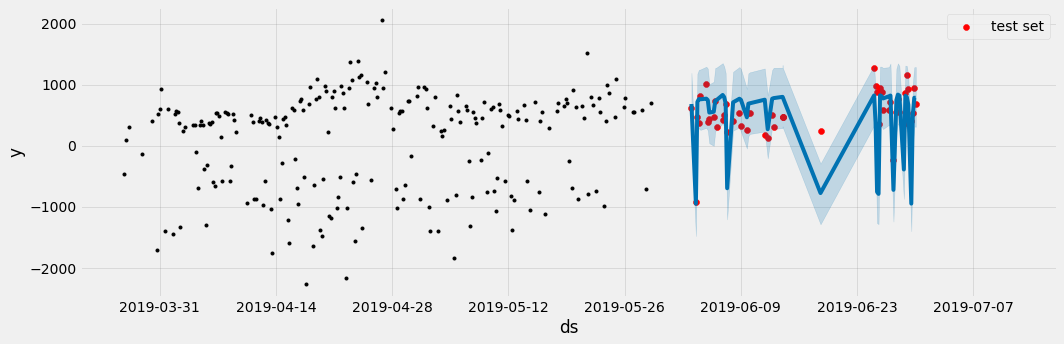

In [34]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = m31.plot(forecast1_co2, ax=ax)

#### There is a big gap in actual data and forecasted data

### Compare the gas flux in test set and in forecasted set

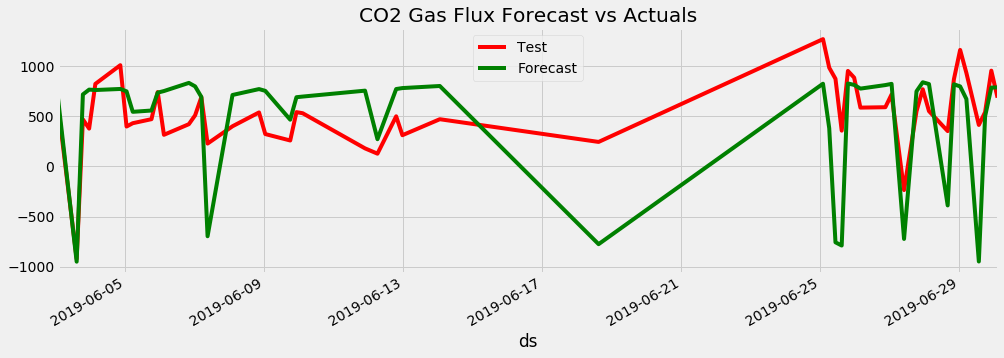

In [35]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast1_co2.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('CO2 Gas Flux Forecast vs Actuals')
plt.show() 

#### There is a  big gap between the actual and forecasted sets. Need to tune this model further. Not saving this model.

In [66]:
#### Now, we will predict by creating future dataframe next dates of train data. 
#make_future_dataframe has include_history = True by default.
#So the prediction will be done for train data as well.

### Forecast for next 1 month

In [67]:
#future21       = m31.make_future_dataframe(periods=30, freq='D')  
#forecast2_co2 = m31.predict(future21)

## Plot the forecast
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#fig = m31.plot(forecast2_co2,ax=ax)
#plt.show()

## Plot the components of the model
#fig1 = m31.plot_components(forecast2_co2)
#fig1.set_figwidth(20)

### Actuals v/s Forecast (simple model)

In [68]:
#df = df_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})

## Plot the forecast with the actuals
#f1, ax = plt.subplots(1)
#f1.set_figheight(5)
#f1.set_figwidth(15)
#ax.scatter(df.ds, df['y'], color='r', label="test set")
#ax.legend()

#fig2 = m31.plot(forecast2_co2, ax=ax)

### Plot the forecast with the actuals for first week of June

In [69]:
#f, ax = plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#ax.scatter(df.ds, df['y'], color='r', label="test set")
#ax.legend()

#fig = m31.plot(forecast1_co2, ax=ax)

#ax.set_xlim([datetime.date(2019, 6, 1), datetime.date(2019, 6, 7)])
#ax.set_ylim(None, None)

#plot = plt.suptitle('First Week of June Forecast vs Actuals')

### Measure the performance of the model

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast1_co2['yhat'])
print("MAPE",round(mape,4))

MAPE 87.1277


### Save the model

In [38]:
pkl_path = "./MyProphetModels/CH4/SimpleModel_m31_CO2.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m31, f)
    
## save the dataframe
forecast1_co2.to_pickle("./MyProphetModels/CH4/forecast_simple_model_forecast1_co2.pkl")

print("*** Data Saved ***")

# To read the Prophet model object
#with open(pkl_path, 'rb') as f:
#    m = pickle.load(f)

#fcast = pd.read_pickle("path/to/data/forecast.pkl")

*** Data Saved ***


### Cross Validation using the simple model

In [39]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

#df_cv = cross_validation(m31, initial='42 days', period='7 days', horizon = '14 days')   
#df_p  = performance_metrics(df_cv)
#df_p

In [40]:
#fig3 = plot_cross_validation_metric(df_cv, metric='mape')

### Generate Model with Tuned Parameters (using HyperParameter Tuning)

### Hyperparameter Tuning
- do hyperparameter tuning using ParameterGrid from sklearn:
   - Hyper Parameters: (as advised by fbProphet authors to be tunable)
     - changepoint_prior_scale
     - seasonality_prior_scale
     - seasonality_mode: additive/multiplicative seasonality (in this case, the seasonality looks more additive)
     - uncertainty intervals - mcmc (bayesian sampling)   (Not Tunable)
- add changepoints, add holiday effect
- do forecast - hourly, daily, weekly
- add met data

### Prophet Model Tuning

In [75]:
params_grid = {
                'seasonality_prior_scale':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 2, 4, 6, 8, 10], # range [0.01, 10]
                'changepoint_prior_scale':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5],    #range [0.001, 0.5]
                'n_changepoints'         :[25,75,125]
              } 

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [76]:
def get_dates(df, start_date, end_date):

    start_date = pd.to_datetime(start_date) #, utc= True)
    end_date   = pd.to_datetime(end_date) #, utc= True) 
    
    series_dates = df.copy()
    series_dates = series_dates.reset_index().drop('ghg', axis=1)
    series_dates

    mask = (series_dates['DateTime'] > start_date) & (series_dates['DateTime'] < end_date)
    filtered_df = series_dates.loc[mask]

    return filtered_df

In [ ]:
start_date = '2019-05-29'
end_date   = '2019-06-29'

actual     = get_dates(dataf, start_date, end_date)  #30 days forecast - to retrieve the dates

model_parameters = pd.DataFrame(columns = ['MAPE', 'Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p) 
    #print('\n')
    random.seed(0)
    
    #weekly_seasonality=False,
    #daily_seasonality=True,
    #yearly_seasonality=False,

    tuned_model1 = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                          seasonality_prior_scale=p['seasonality_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          interval_width=0.95
                         )
    tuned_model1.fit(dataframe_train_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))
    
    #by default, include_history=true, it means it will include train data as well
    #future3       = tuned_model.make_future_dataframe(periods=30, freq='D', include_history = False) 
    future31 = tuned_model1.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

    #Calculate the performance metric
    MAPE = mean_absolute_percentage_error(y_true=dataframe_test_CO2dry['Flux'], y_pred=future31['yhat'])
    print('Mean Absolute Percentage Error (MAPE)-------------------', MAPE)
    model_parameters = model_parameters.append({'MAPE': MAPE, 'Parameters': p}, ignore_index=True)
    print('\n')

#### Print the dataframe containing the parameter combinations and the performance metric result

In [78]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
parameters

,MAPE,Parameters
0,38.143682,"{'changepoint_prior_scale': 0.4, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}"
1,38.244476,"{'changepoint_prior_scale': 0.4, 'n_changepoints': 25, 'seasonality_prior_scale': 0.01}"
2,38.268053,"{'changepoint_prior_scale': 0.05, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}"
3,38.344803,"{'changepoint_prior_scale': 0.4, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}"
4,38.389711,"{'changepoint_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}"
5,38.399872,"{'changepoint_prior_scale': 0.2, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}"
6,38.641117,"{'changepoint_prior_scale': 0.2, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}"
7,39.327244,"{'changepoint_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}"
8,39.336197,"{'changepoint_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_prior_scale': 0.01}"
9,39.485092,"{'changepoint_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_prior_scale': 0.01}"


In [79]:
parameters.to_csv('HyperParameter_Tuning_Results_CO2_final_model1.csv')

#### Print the parameter combination for the best model (i.e. with least MAPE value)

In [80]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'n_changepoints': 125,
 'seasonality_prior_scale': 0.01}

#### Set up the final model with the above parameters
{'changepoint_prior_scale': 0.4,
 'n_changepoints': 125,
 'seasonality_prior_scale': 0.01}

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


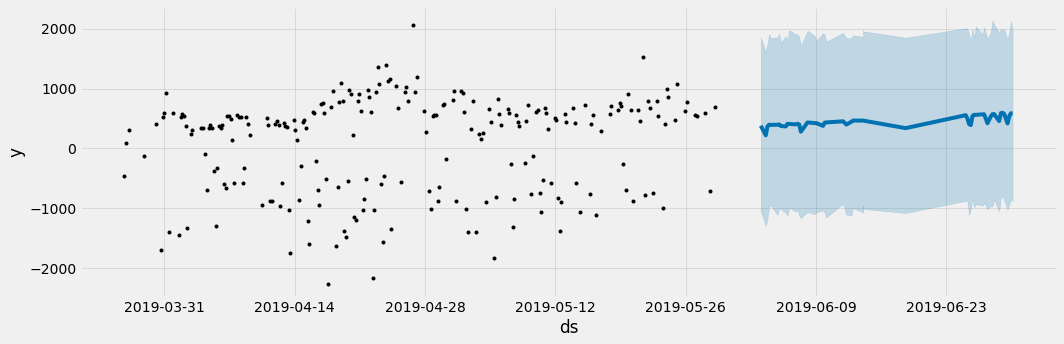

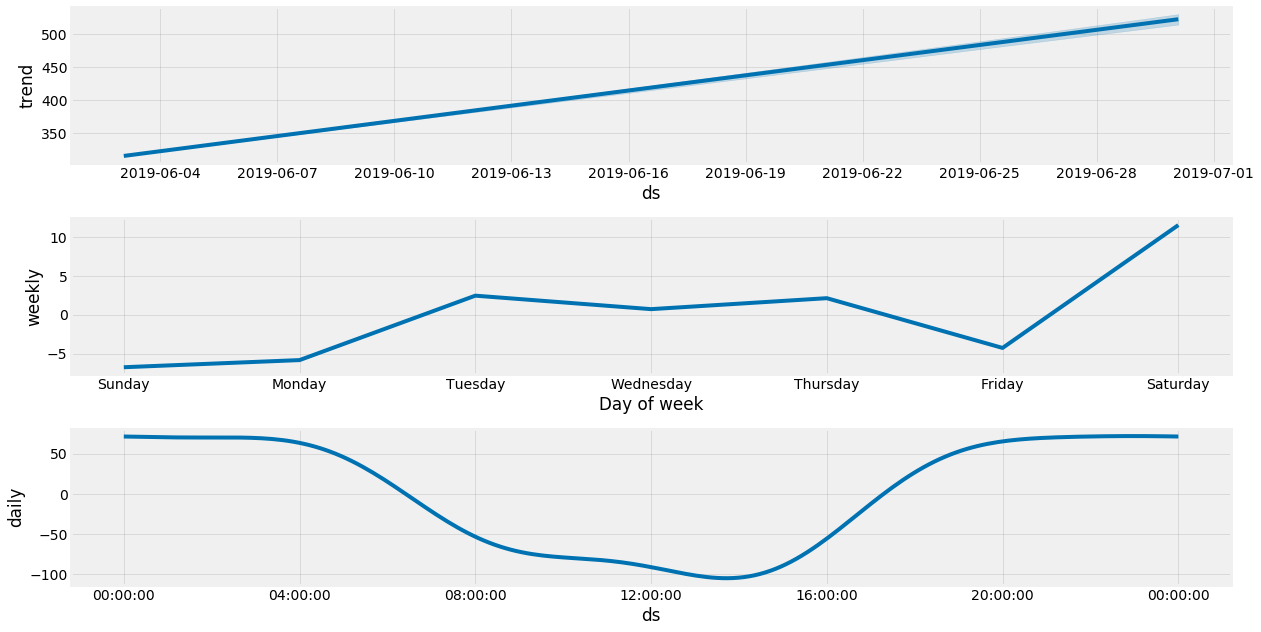

In [41]:
final_model1 = Prophet(changepoint_prior_scale=0.4,
                      seasonality_prior_scale=0.01,
                      n_changepoints= 125,
                      interval_width=0.95)

final_model1.fit(dataframe_train_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))

forecast_tunedmodel_v11 = final_model1.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model1.plot(forecast_tunedmodel_v11,ax=ax)
plt.show()

# Plot the components of the model
fig1 = final_model1.plot_components(forecast_tunedmodel_v11)
fig1.set_figwidth(20)

### Measure the performance of the tuned model final_model1

In [82]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast_tunedmodel_v11['yhat'])
print("MAPE",round(mape,4))

MAPE 38.1437


### Use Cross Validation for tuned_model v1

In [42]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

df_cv11 = cross_validation(final_model1, initial='42 days', period='7 days', horizon = '14 days')   
df_p11  = performance_metrics(df_cv11)
#df_p11

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:33:00 and 2019-05-15 03:33:00


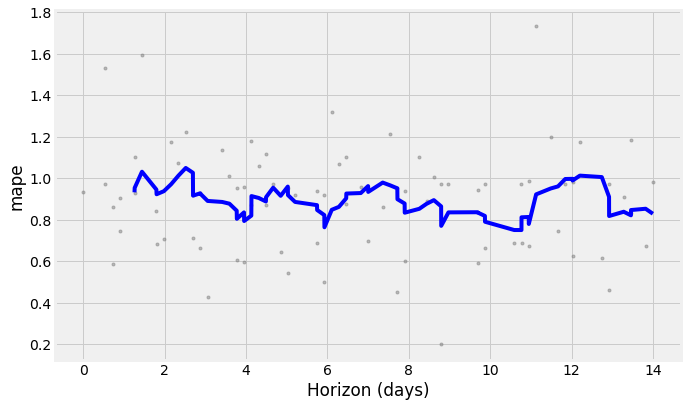

In [84]:
fig3 = plot_cross_validation_metric(df_cv11, metric='mape')

#### Compare Forecast vs Actual using tuned model v1

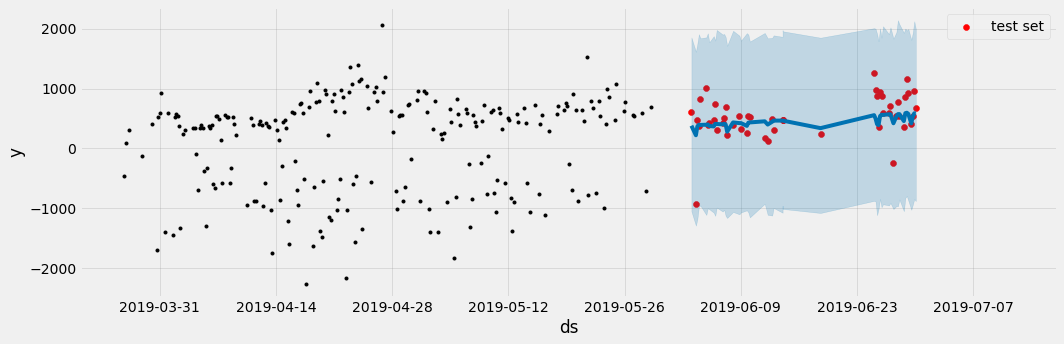

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = final_model1.plot(forecast_tunedmodel_v11, ax=ax)

#### Compare gas flux in test set and the forecasted set

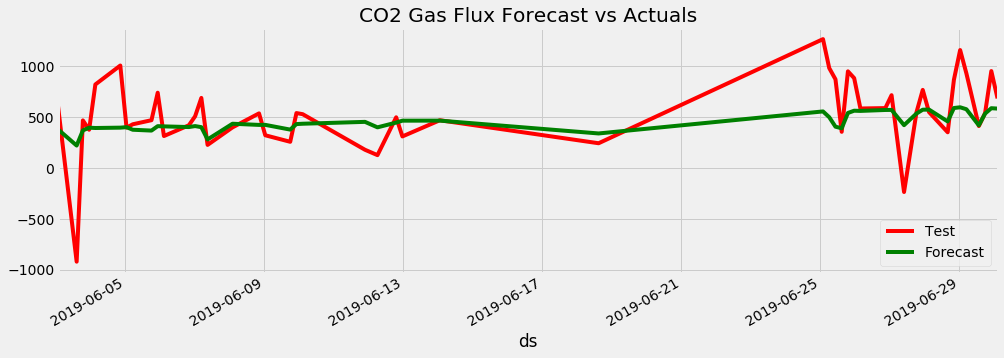

In [44]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_tunedmodel_v11.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('CO2 Gas Flux Forecast vs Actuals')
plt.show() 

#### Forecast for next 48 hours

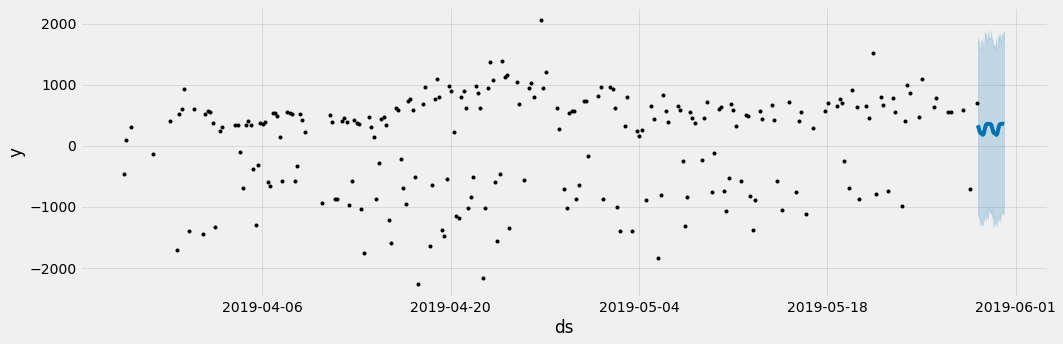

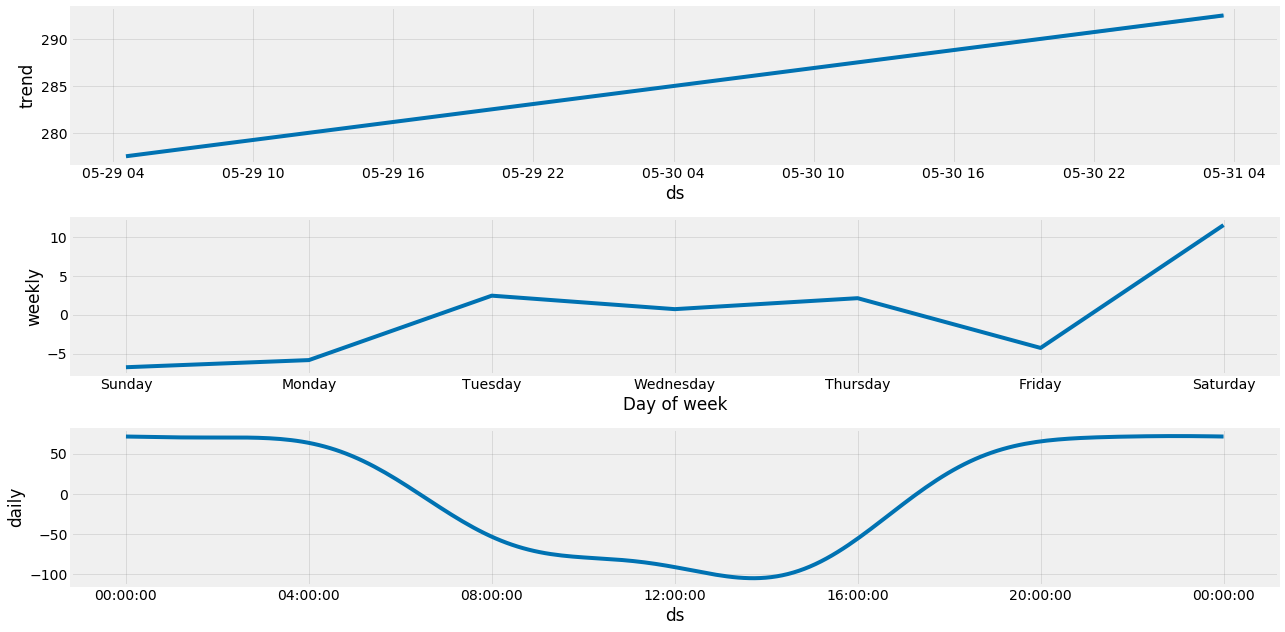

In [87]:
future_48h1       = final_model1.make_future_dataframe(periods=48, freq='H', include_history = False) 
forecast_48hours1 = final_model1.predict(future_48h1)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model1.plot(forecast_48hours1,ax=ax)
plt.show()

# Plot the components of the model
fig1 = final_model1.plot_components(forecast_48hours1)
fig1.set_figwidth(20)

#### Forecast for next 2 weeks

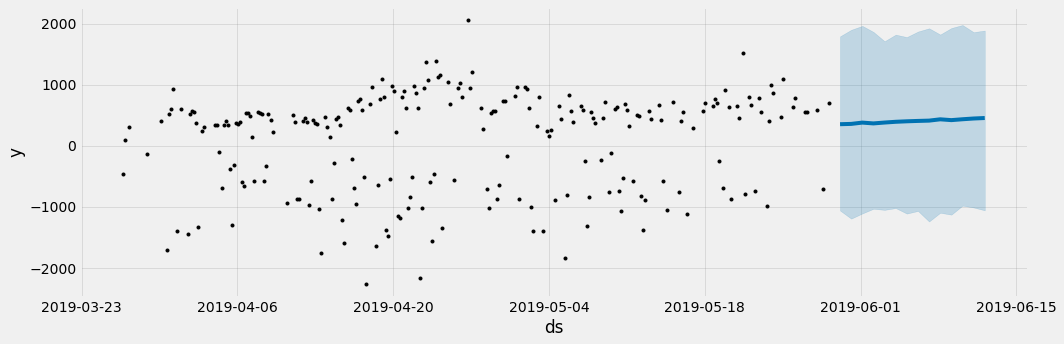

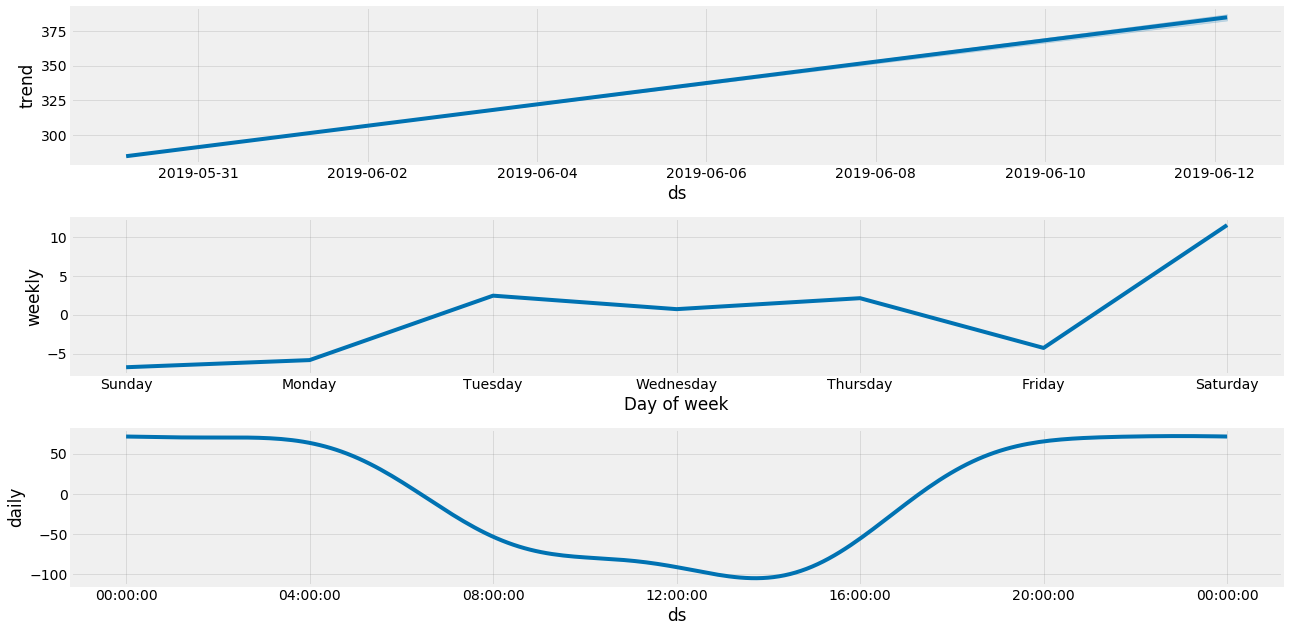

In [88]:
future_2wks1    = final_model1.make_future_dataframe(periods=14, freq='D', include_history = False) 
forecast_2wks1  = final_model1.predict(future_2wks1)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model1.plot(forecast_2wks1,ax=ax)
plt.show()

# Plot the components of the model
fig1 = final_model1.plot_components(forecast_2wks1)
fig1.set_figwidth(20)

### Save the tuned model (final model1)

In [46]:
pkl_path = "./MyProphetModels/CO2/TunedModel_v1_CO2.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(final_model1, f)
    
# save the dataframe
forecast_tunedmodel_v11.to_pickle("./MyProphetModels/CO2/forecast_tunedmodel_v11.pkl")
#forecast_48hours1.to_pickle("./MyProphetModels/CO2/forecast_48hours1.pkl")
#forecast_2wks1.to_pickle("./MyProphetModels/CO2/forecast_2wks1.pkl")

print("*** Data Saved ***")

# To read the Prophet model object
#with open(pkl_path, 'rb') as f:
#    m = pickle.load(f)

#fcast = pd.read_pickle("path/to/data/forecast.pkl")

*** Data Saved ***


### Using a different approach - different combinations of parameters + newer parameters

In [47]:
#specify a cap and floor for limiting the forecast within these values

df = dataframe_train_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df['cap']   = 5000
df['floor'] = -2000

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m5 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m5.fit(history_df)    
    df_cv = cross_validation(m5, initial='42 days', period='7 days', horizon = '14 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
                #'weekly_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

In [ ]:
results_df.to_csv('HyperParameter_Tuning_Results_CO2_mTv1.csv')

In [ ]:
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')

### Create final model mT_v1 with the actual parameter combination

In [48]:
mT_v1 = Prophet(
    changepoint_prior_scale=0.2,
    changepoint_range=0.9,
    seasonality_prior_scale=10.0,
    seasonality_mode='multiplicative',
    growth='linear'
)

mT_v1.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the final model mT_v1 with the actual parameter combination

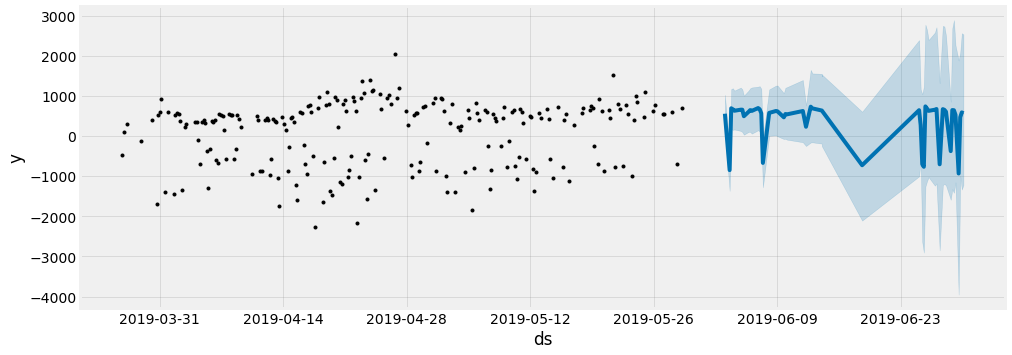

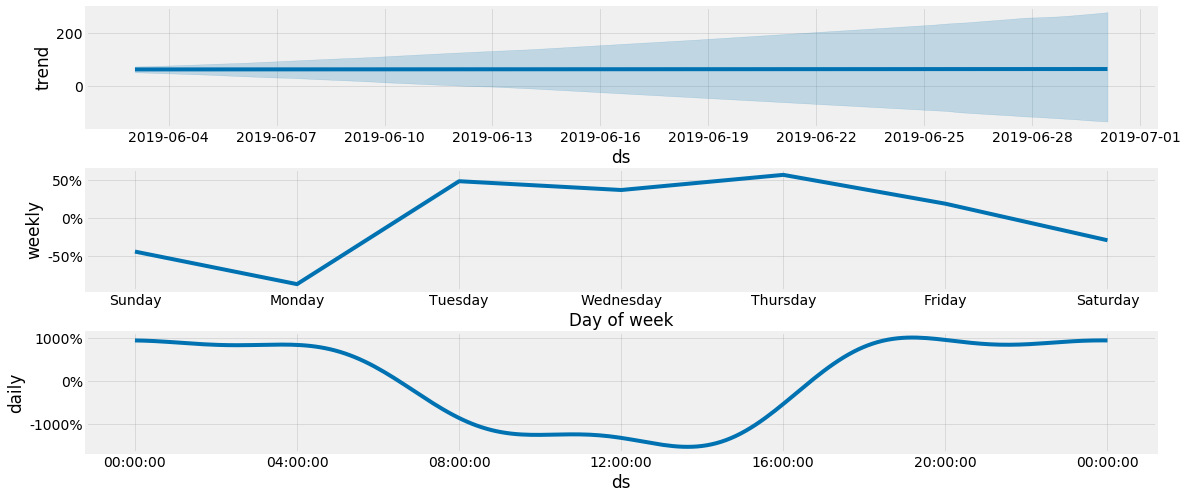

In [49]:
#mT.add_country_holidays(country_name='US')

forecast_mT_v1 = mT_v1.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

#
#future['cap'] = 60000
#future['floor'] = 0
fig21          = mT_v1.plot(forecast_mT_v1)
fig22          = mT_v1.plot_components(forecast_mT_v1)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Check the performance of the tuned model mT_v1

In [50]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast_mT_v1['yhat'])
print("MAPE",round(mape,4))

MAPE 76.3679


In [ ]:
mse = sklearn.metrics.mean_squared_error(dataframe_test_CH4dry,forecast_mT_v1)

rmse = math.sqrt(mse)

print(rmse)

### Compare Forecast vs Actual using Tuned Model mT_v1

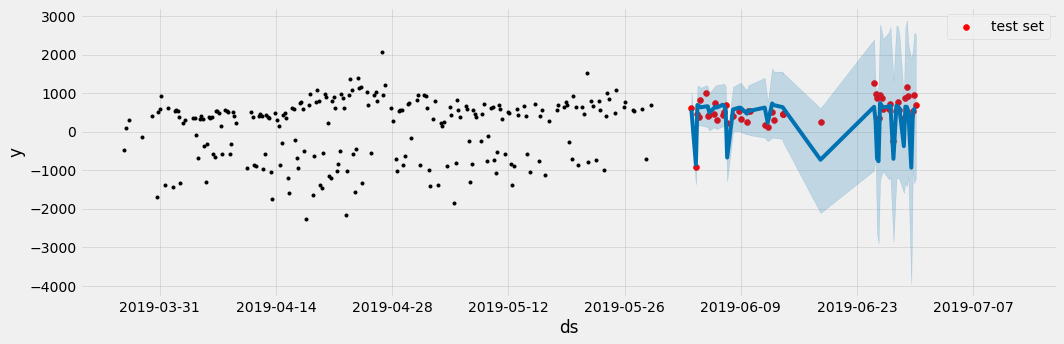

In [51]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v1.plot(forecast_mT_v1, ax=ax)

### Compare the gas flux in test set and in forecasted set

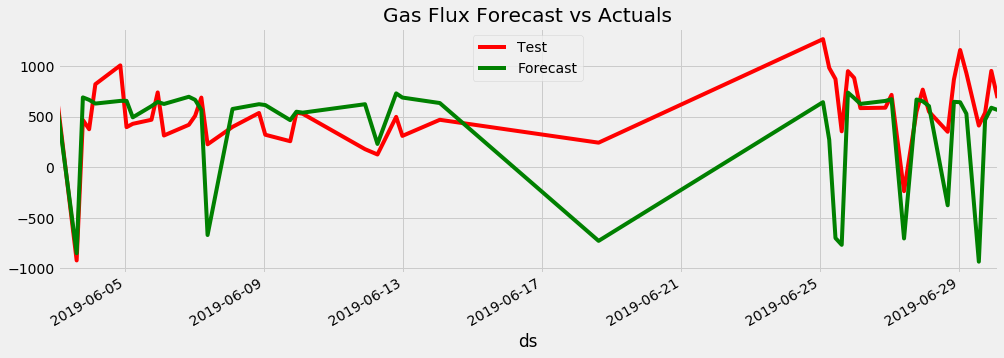

In [52]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Cross Validation of the tuned model mT_v1

In [ ]:
#horizon = how many days are we going to make forecast 
#period  = space between 2 or more training periods (normally 0.5 * horizon)
#initial = size of training period (normally 3* horizon)

df_cv21 = cross_validation(mT_v1, initial='42 days', period='7 days', horizon = '14 days')   
df_p21 = performance_metrics(df_cv21)
df_p21

In [ ]:
fig3 = plot_cross_validation_metric(df_cv21, metric='mape')

## Run the tuned model mT_v1 with the actual parameter combination to generate forecasts on the gas flux

### Forecast next 30 days using model mT_v1

In [ ]:
futureT                    = mT_v1.make_future_dataframe(periods=30, freq='D', include_history = True)   #include_history = False
forecast_mT_v1             = mT_v1.predict(futureT)

fig21                      = mT_v1.plot(forecast_mT_v2)
fig21.set_figwidth(12)
fig21.set_figheight(6)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv2_model_output.png" 
# save as png
plt.savefig(plot_file_name)


fig22                      = mT_v1.plot_components(forecast_mT_v1)
fig22.set_figwidth(15)
fig22.set_figheight(10)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CH4_gasflux_Plot"+plotId+"_mTv2_components_output.png" 
# save as png
plt.savefig(plot_file_name)

### Compare forecasted (30 days) using tuned model mT_v1 with test data set

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v2.plot(forecast_mT_v1, ax=ax)

### Forecast for next 48 hours

In [ ]:
future_48hT1           = mT_v1.make_future_dataframe(periods=48, freq='H', include_history = False) 
forecast_mT_v1_hoursT  = mT_v1.predict(future_48hT1)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v1.plot(forecast_mT_v1_hoursT,ax=ax)
plt.show()

# Plot the components of the model
fig1 = mT_v1.plot_components(forecast_mT_v1_hoursT)
fig1.set_figwidth(20)

### Forecast for next 2 weeks

In [ ]:
future_2W1           = mT_v1.make_future_dataframe(periods=14, freq='D', include_history = False) 
forecast_mT_v1_2Wks  = mT_v1.predict(future_2W1)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v1.plot(forecast_mT_v1_2Wks,ax=ax)
plt.show()

# Plot the components of the model
fig1 = mT_v1.plot_components(forecast_mT_v1_2Wks)
fig1.set_figwidth(20)

#### Uncertainty is high in next 2 weeks - hence the trend seems to be positive (going slightly upwards

### Forecast for next 2 months

In [ ]:
future_2M1        = mT_v1.make_future_dataframe(periods=30*2, freq='D', include_history = False) 
forecast_mT_v1_2M = mT_v1.predict(future_2M1)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v1.plot(forecast_mT_v1_2M,ax=ax)
plt.show()

# Plot the components of the model
fig1 = mT_v1.plot_components(forecast_mT_v1_2M)
fig1.set_figwidth(20)

#### Same for forecast over 2 months - trend is slightly upwards with a higher uncertainty range. We need to train the model with more data.

### Compare actual(training) vs forecast (2 weeks) using tuned model mT_v1

In [ ]:
f1, ax = plt.subplots(1)
f1.set_figheight(5)
f1.set_figwidth(15)
ax.scatter(df.ds, df['y'], color='r', label="test set")
ax.legend()

fig2 = mT_v1.plot(forecast_mT_v1_2Wks, ax=ax)

### Compare entire set vs forecast (2 weeks) using tuned model mT_v1

In [ ]:
df1 = df_CO2dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})

# Plot the forecast with the actuals
f1, ax = plt.subplots(1)
f1.set_figheight(5)
f1.set_figwidth(15)
ax.scatter(df1.ds, df1['y'], color='r', label="test set")
ax.legend()

fig2 = mT_v1.plot(forecast_mT_v1_2Wks, ax=ax)

#### We can see from the above plot, that the model us accurate. 
So we need to optimize the model by adding other parameters like holidays, changepoints etc.

## Using a second approach - try a different combination of parameters

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m6 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m6.fit(history_df)    
    df_cv = cross_validation(m6, initial='42 days', period='7 days', horizon = '14 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                'weekly_seasonality': [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    
results_df11 = pd.concat(results).reset_index(drop=True)
best_param = results_df11.loc[results_df11['mape'] == min(results_df11['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
#results_df.to_csv("HyperParameterTuning_CH4Modelv2")
results_df11

In [ ]:
results_df11.to_csv('HyperParameter_Tuning_Results_CO2_mTv2.csv')

In [ ]:
best_param = results_df11.loc[results_df11['mape'] == min(results_df11['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')

### Create final model mT_v2 with the actual parameter combination

In [53]:
mT_v2 = Prophet(
    changepoint_prior_scale=0.1,
    changepoint_range=0.8,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive',
    growth='linear',
    weekly_seasonality=1
)

mT_v2.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the final model mT_v2 with the actual parameter combination

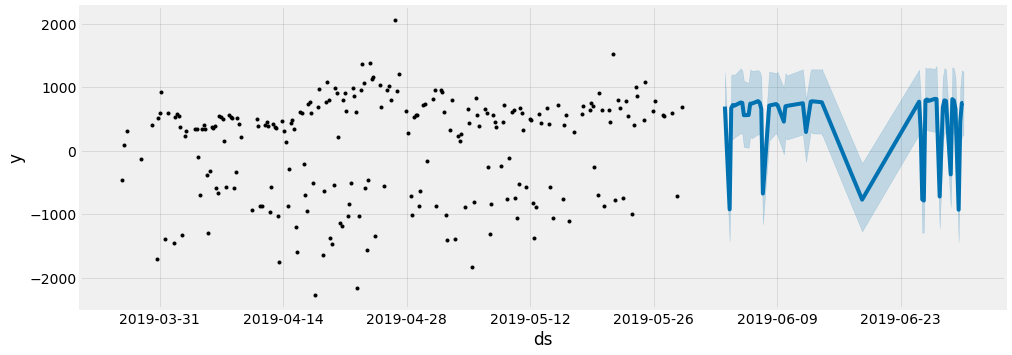

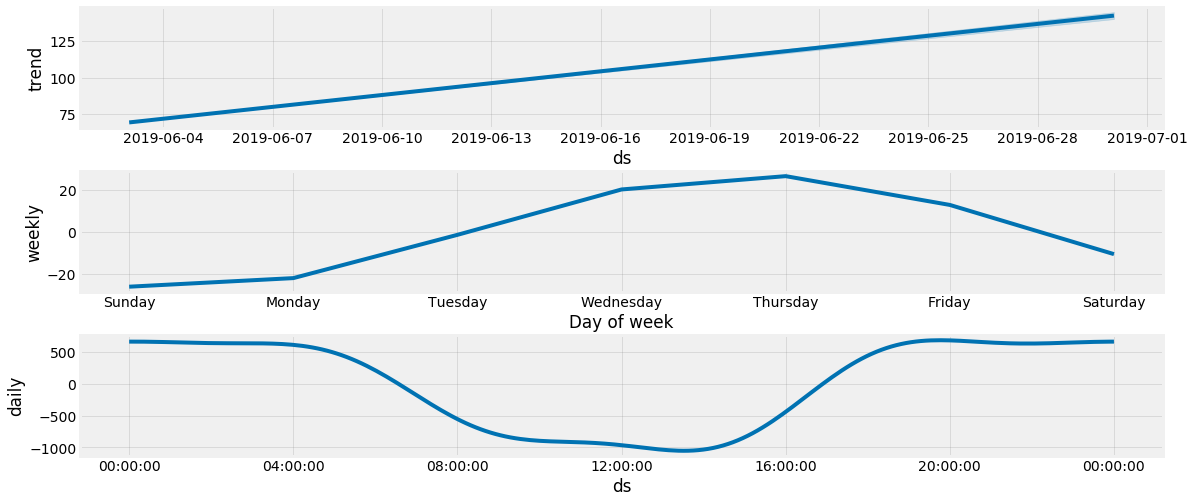

In [54]:
#mT.add_country_holidays(country_name='US')

forecast_mT_v2 = mT_v2.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

#
#future['cap'] = 60000
#future['floor'] = 0
fig21          = mT_v2.plot(forecast_mT_v2)
fig22          = mT_v2.plot_components(forecast_mT_v2)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Check the performance of the tuned model mT_v2

In [55]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast_mT_v2['yhat'])
print("MAPE",round(mape,4))

MAPE 85.6456


In [56]:
#import sklearn
#import math

#mse = sklearn.metrics.mean_squared_error(dataframe_test_CO2dry['Flux'],forecast_mT_v2['yhat'])

#rmse = math.sqrt(mse)

#print(rmse)

### Compare Forecast vs Actual using Tuned Model mT_v2

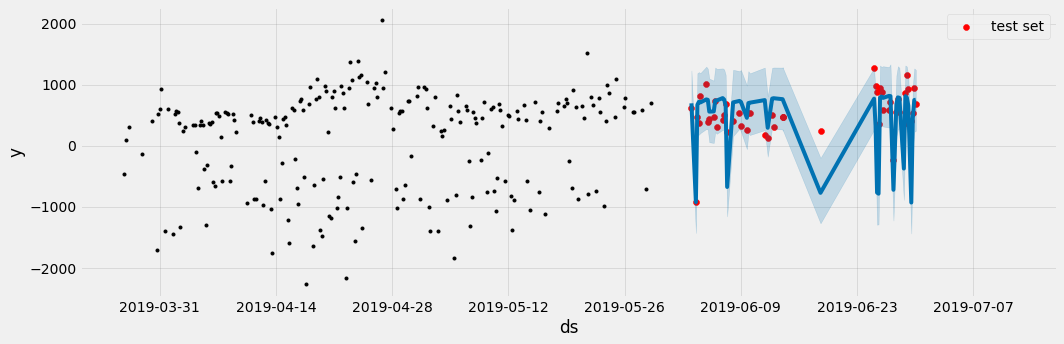

In [57]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v2.plot(forecast_mT_v2, ax=ax)

### Compare gas flux in test and forecasted set

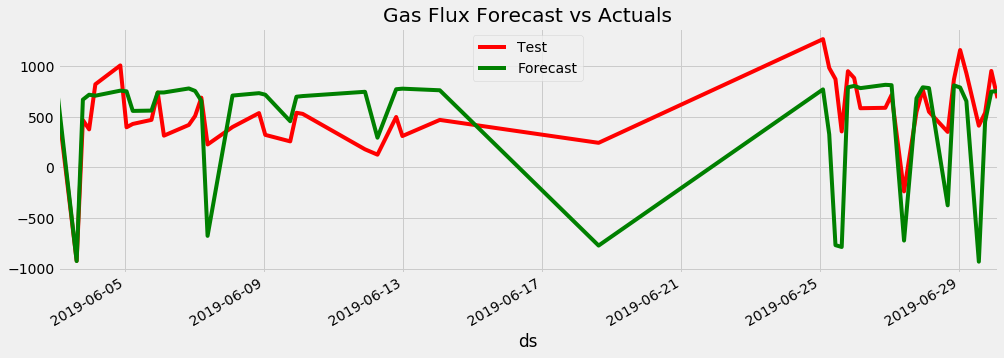

In [58]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v2.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Using a third approach - try a different combination of parameters

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m6 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m6.fit(history_df)    
    df_cv = cross_validation(m6, initial='42 days', period='7 days', horizon = '14 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                'daily_seasonality': [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    
results_df3 = pd.concat(results).reset_index(drop=True)
best_param = results_df3.loc[results_df3['mape'] == min(results_df3['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
#results_df.to_csv("HyperParameterTuning_CH4Modelv2")
results_df3

In [ ]:
results_df3.to_csv("HyperParameterTuning_CO2_model_mT_v3")

best_param = results_df3.loc[results_df3['mape'] == min(results_df3['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')

### Create the finalised model mT_v3 from the above combination

In [59]:
mT_v3 = Prophet(
    changepoint_prior_scale=0.1,
    changepoint_range=0.8,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive',
    growth='linear',
    #yearly_seasonality = False,
    daily_seasonality = 3
)

mT_v3.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Run the finalised model mT_v3 (with the new combination set) to predict test data set

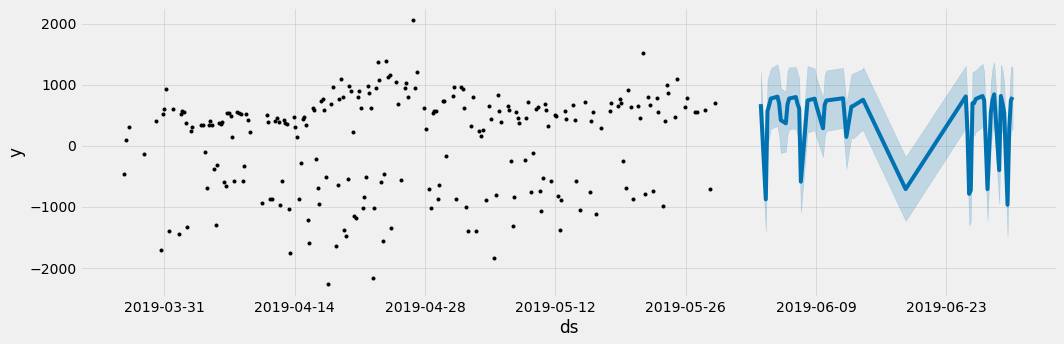

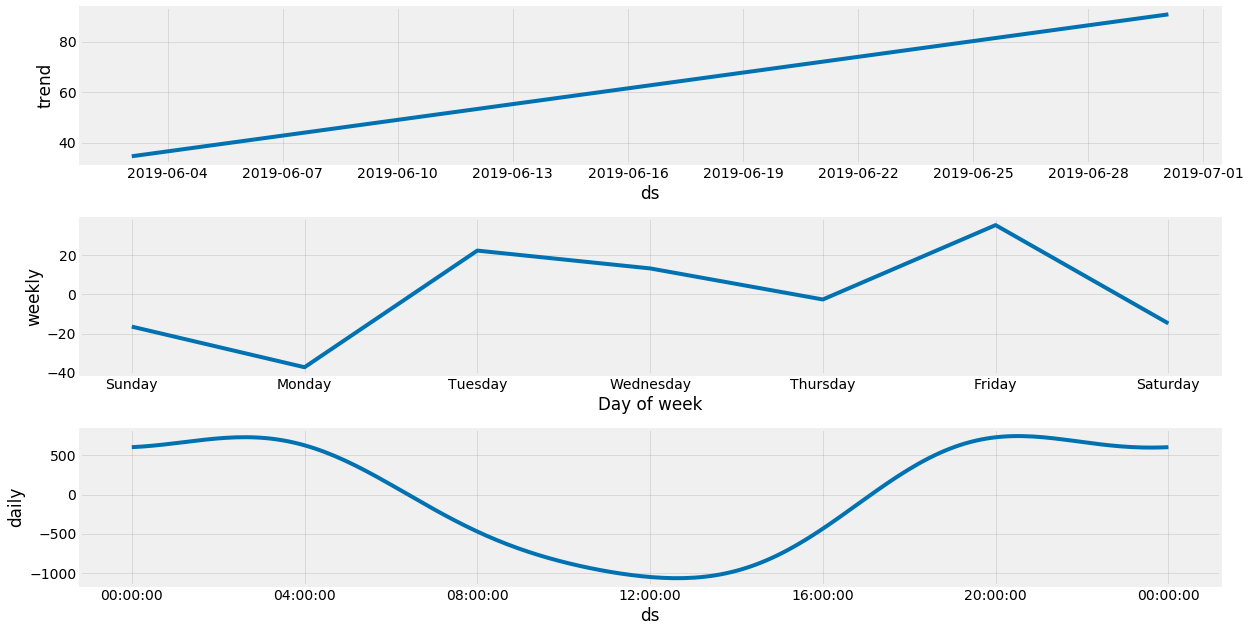

In [60]:
#df = dataframe_train_CH4dry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})  

forecast_mT_v3 = mT_v3.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

#future_test    = final_model.make_future_dataframe(periods=14, freq='D', include_history = False) 
#forecast_test  = final_model.predict(future_test)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mT_v3.plot(forecast_mT_v3,ax=ax) #forecast_test
plt.show()

# Plot the components of the model
fig1 = mT_v3.plot_components(forecast_mT_v3)
fig1.set_figwidth(20)

### Compare Forecast vs Actual using Tuned Model mT_v3

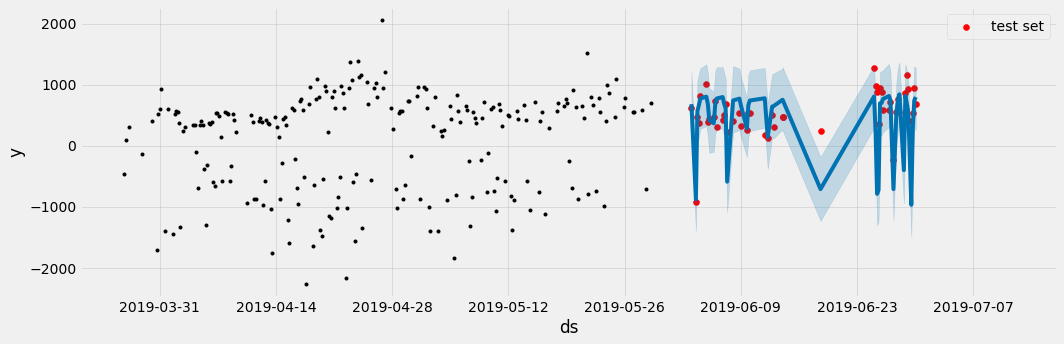

In [61]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v3.plot(forecast_mT_v3, ax=ax)

### Compare the gas flux in test set and in forecasted set

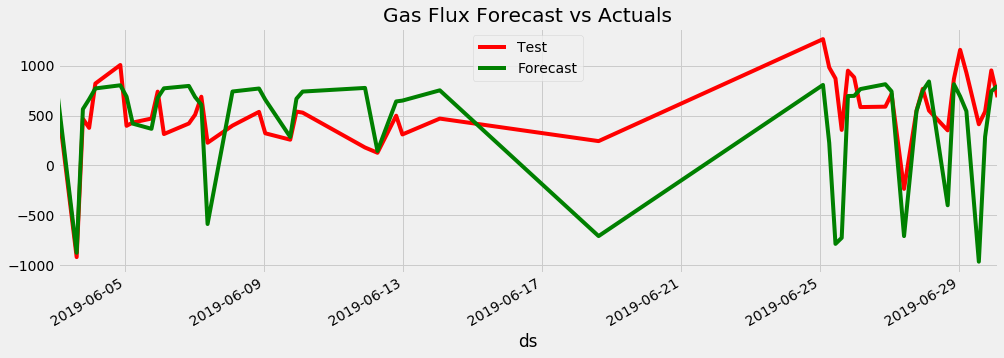

In [62]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v3.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Test the performance of the model

In [63]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast_mT_v3['yhat'])
print("MAPE",round(mape,4))

MAPE 79.2613


In [ ]:
#mse = sklearn.metrics.mean_squared_error(dataframe_test_CH4dry,forecast_mT_v3)

#rmse = math.sqrt(mse)

#print(rmse)

In [64]:
#mT_v4 = Prophet(
#    changepoint_prior_scale=5.0,
#    changepoint_range=0.8,
#    seasonality_prior_scale=1.0,
#    n_changepoints=25,
#    seasonality_mode='multiplicative',
#    growth='linear',
#    weekly_seasonality=5
#)

mT_v4 = Prophet(
    changepoint_prior_scale= 5, #0.05
    changepoint_range= 0.8,
    #n_changepoints= 125,
    seasonality_prior_scale= 1, #0.1,
    seasonality_mode = 'multiplicative',
    growth = 'linear' 
)
    
mT_v4.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


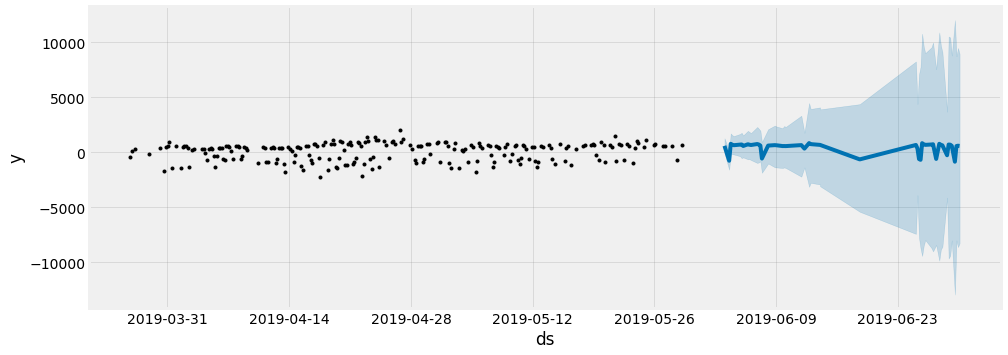

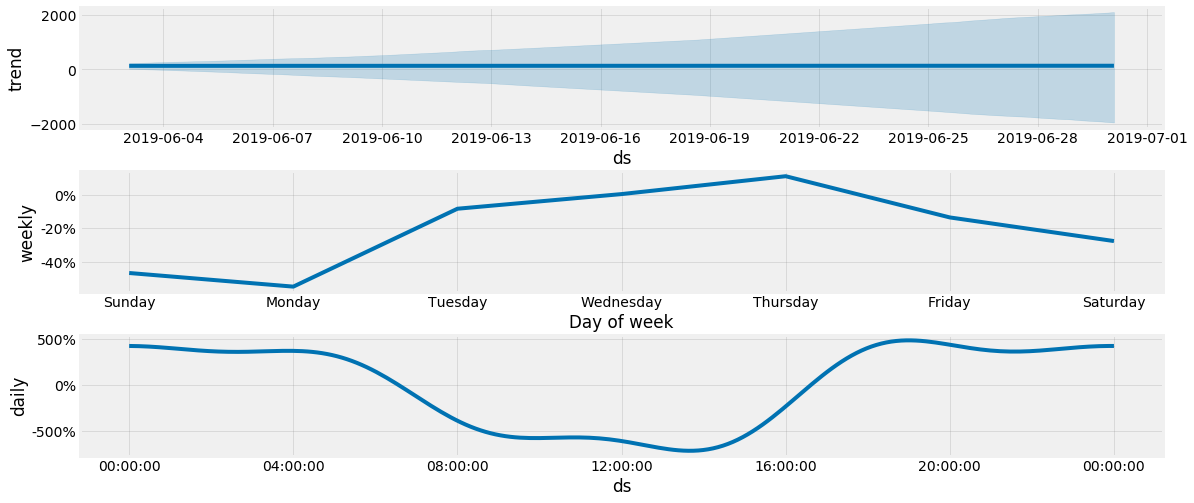

In [65]:
forecast_mT_v4 = mT_v4.predict(df=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'}))

fig21          = mT_v4.plot(forecast_mT_v4)
fig22          = mT_v4.plot_components(forecast_mT_v4)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

In [66]:
mape = mean_absolute_percentage_error(dataframe_test_CO2dry['Flux'],forecast_mT_v4['yhat'])
print("MAPE",round(mape,4))

MAPE 78.3985


### Compare Forecast vs Actual using resampled data Model

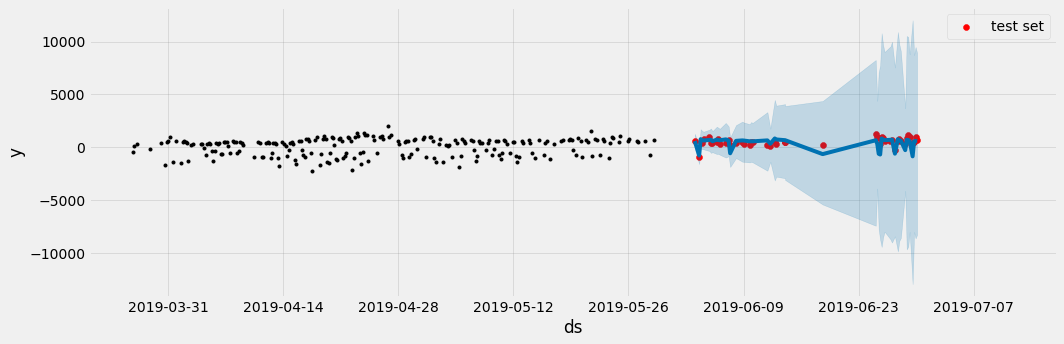

In [67]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_CO2dry.index, dataframe_test_CO2dry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v4.plot(forecast_mT_v4, ax=ax)

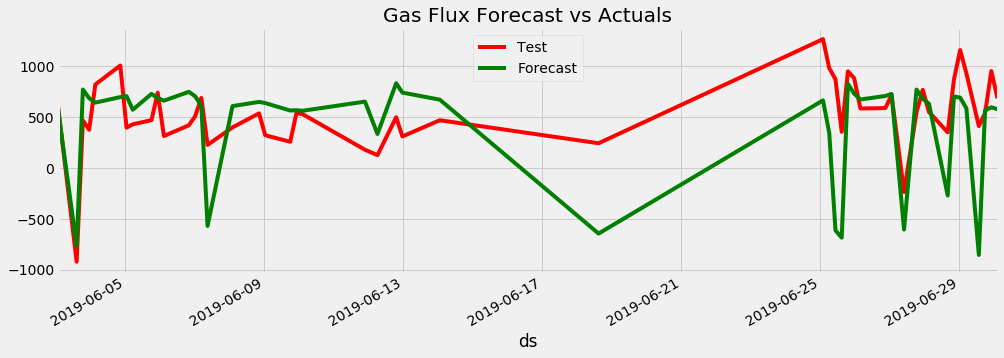

In [68]:
df1=dataframe_test_CO2dry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v4.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

In [ ]:
# Resample from weekly to monthly
#co2_month = CO2.resample('MS').mean()

# Backfill any missing values
#co2_month.fillna(method='bfill', inplace=True)

#co2_month.head()

#### Notes about the different model parameters

##### Multiplicative seasonality
By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. 
This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality.

##### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. Prophet is able to detect
and fit these, but what trend changes should we expect moving forward? It’s impossible to know for sure, so we do the
most reasonable thing we can, and we assume that the future will see similar trend changes as the history. 
In particular, we assume that the average frequency and magnitude of trend changes in the future will be the 
same as that which we observe in the history. We project these trend changes forward and by computing their
distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing changepoint_prior_scale, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

the forecasted trend may vary between yhat_lower and yhat_upper

##### Uncertainty in seasonality
To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter mcmc.samples 
(which defaults to 0). 

### Hide code for printing/visualising purposes

In [69]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')